<h3 style="color:#f20000;">Importer les librairies et modules nécessaires</h3>

In [2]:
# Tensorflow:un outil open source d'apprentissage automatique, maintenue par Google
import tensorflow as tf
# OpenCV :spécialisée dans le traitement d'images en temps réel
import cv2
# os: module qui permet interagir avec le système d'exploitation, de gérer l’arborescence des fichiers, 
# de fournir des informations sur le système d'exploitation processus, variables systèmes, ainsi que de nombreuses fonctionnalités du systèmes
import os
# random: ce module implémente des générateurs de nombres pseudo-aléatoires pour différentes distributions
import random
# numpy:destinée à manipuler des matrices ou tableaux multidimensionnels ainsi que des fonctions mathématiques opérant sur ces tableaux
import numpy as np
# glob: un module utilisé pour trouver tous les noms de chemins qui correspondent à un modèle spécifié. 
# Il offre un moyen pratique de rechercher des fichiers et des répertoires en utilisant des caractères génériques.
import glob

# Modules permettant de lire et afficher les images 
from skimage.io import imread, imshow
# Modules permettant de redimensionnerles images 
from skimage.transform import resize
# Librairie utilisée pour le dessin de graphes 
import matplotlib.pyplot as plt
# Modules permettant de définir les différents types de couches 
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
# Module permettant la définition d'un modèle
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# la fonction Seed est utilisée pour sauvegarder l'état d'une fonction random pour qu'elle génère le même résultat aléatoire à chaque executions du code
random.seed(23)

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

<h3 style="color:#f20000;">Définir une fonction pour redimentionner les données d'entrée</h3>

In [3]:
def img_resize(image, y_dim, x_dim):
    resized_img = cv2.resize(image, (y_dim,x_dim))
    return resized_img

<h3 style="color:#f20000;">Importer les images et leurs masques</h3>
<strong>
<br>Les images importées des plans d'eau sont des images capturées par le satellite Sentinel 2 de différentes dimensions au environs de 1500*1700. 
<br>Pour chaque image, un masque lui est correspondant avec une zone blanche représentant l'eau et une noire représentant le reste. <br>Les masques ont été générées en calculant l'indice de différence normalisée de l'eau NDWI utilisé pour détecter les plans d'eau.
<br>NDWI = (NIR-SWIR)/(NIR+SWIR) 
<br>NIR:Near InfraRed
<br>SWIR: Short Wave InfraRed.

<br> La source du DataSet: https://www.kaggle.com/datasets/franciscoescobar/satellite-images-of-water-bodies/code
    <strong>

In [4]:
image_path = "/kaggle/input/satellite-images-of-water-bodies/Water Bodies Dataset/Images/*.jpg"
mask_path = "/kaggle/input/satellite-images-of-water-bodies/Water Bodies Dataset/Masks/*.jpg"

<h3 style="color:#f20000;">Ordonner les noms des images d'origine avec leurs masques </h3>

<strong>
Il se peut que le système opérateur charge les données dans un ordre autre que celui donné, d'ou la nécessité d'ordonner les données et attribuer à chaque image son masque correspondant et ceci en utilisant le texte inscrit comme nom avant '.jpg'
</strong>

In [5]:
# glob.glob retourne une liste des éléments contenus dans un dossier indiqué (_path) et qui correspond à une extension mensionné (.jpg)
# sorted va ordonner cette liste selon une critère (key) 
# lambda est utilisée pour créer une fonction anonyme (x.split) à travers une variable x
image_names = sorted(glob.glob(image_path), key=lambda x: x.split('.')[0])
mask_names = sorted(glob.glob(mask_path), key=lambda x: x.split('.')[0])

In [6]:
#créer une liste vide des images 
train_images_array = []

for image in image_names:
# charger les images d'origine sans modifier les couleurs (-1)
    img = cv2.imread(image, -1)
# redimensionner l'image chargée en 128*128 pixels
    img = img_resize(img, 128, 128)
# ajouter l'image à la liste créée
    train_images_array.append(img)

# transformer la liste en un tableau
train_images_array = np.array(train_images_array)

In [7]:
#charger, redimentionner et disposer les masques dans un tableau
mask_images_array = []

for mask in mask_names:
# charger les masques en nuances de gris (0)
    msk = cv2.imread(mask, 0)
    msk = img_resize(msk, 128, 128)
    mask_images_array.append(msk)
    
mask_images_array = np.array(mask_images_array)

<h3 style="color:#f20000;">Vérifier la dimension des tableaux créés</h3>

In [8]:
len(train_images_array)

2841

In [9]:
len(mask_images_array)

2841

In [10]:
#dimension de l'image 1 (0)
train_images_array[0].shape

(128, 128, 3)

In [11]:
mask_images_array[0].shape

(128, 128)

<h3 style="color:#f20000;">Normaliser les tableaux créés</h3>

<strong>Le but de normaliser les données est de convertir les valeurs numériques des pixels en une échelle commune entre 0 et 1, ce qui permet d'améliorer la performance et la stabilité d'entrainement du modèle</strong>

In [12]:
def normalize_array(arr):
    return arr/255.0

X = normalize_array(train_images_array)
y = normalize_array(mask_images_array)

<h3 style="color:#f20000;">Visualiser des images aléatoires avec leurs masques</h3>

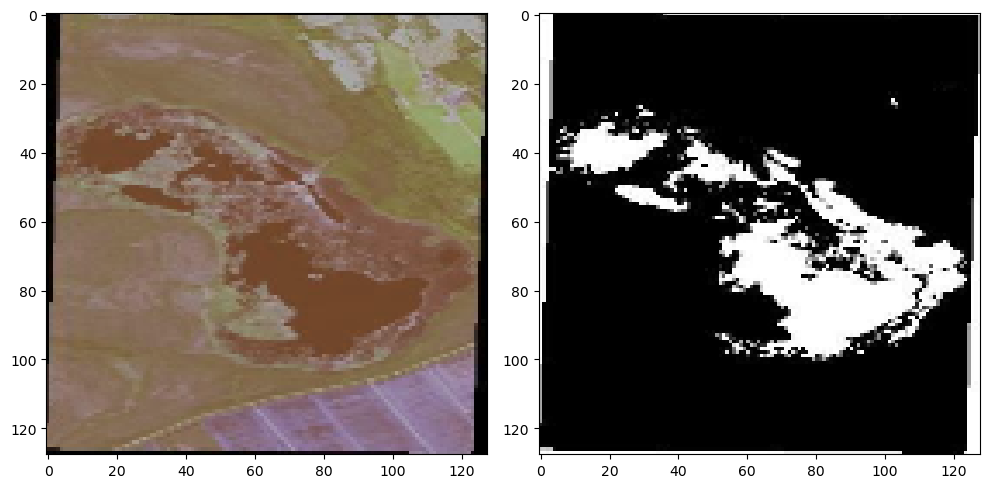

In [13]:
#randint retourne un nombre aléatoire appartenant à l'intervalle mentionné
rand_num = random.randint(0,2500)

#subplots permet d'organiser différents tracés à l'intérieur d'une grille d'affichage.
#Il faut spécifier le nombre de lignes (1), le nombre de colonnes (2) ainsi que la taille d'affichage de la figure
figure, axes = plt.subplots(1,2, figsize=(10,10))

#le premier 'axes' correspond à l'image et le deuxième à son masque
axes[0].imshow(X[rand_num])
axes[1] = imshow(y[rand_num])

<h3 style="color:#F20000;">Diviser les images en entrainement et vérification </h3>

In [14]:
#sklearn modèle qui divise le dataset en données d'entrainement et de vérification d'une manière aléatoire
from sklearn.model_selection import train_test_split

#le pourcentage des données de vérification est de 20%
#random_state est utilisé pour donner les même résultat à chaque exécution
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=23)

<h3 style="color:#F20000;">Créer une fonction pour le chemin encodeur du modèle UNet</h3>

<strong> Le chemin compressif de UNet est constitué d'une succession de couches de convolution et pooling répétitives, raison pour laquelle on a penser à créer une fonction définissant ce processus
<br> la couche de convolution permet d'extraire les caractéristiques de l'image en multipliant celle-ci par une matrice Kernel auquel s'ajoute un biais et le tout passe par une fonction d'activation ReLU, le résultat est une carte de caractéristiques
<br> La couche de pooling permet de réduire la taille de l'image en deux en gardant la valeur maximale des pixels
</strong>

In [15]:
#he_normal est un initilisateur de Kernel,il tire des échantillons d'une distribution normale tronquée centrée sur 0 
#avec une déviation standard = sqrt(2 / nombre des unités d'entrée dans la matrice poids)
def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):
    
    conv = Conv2D(n_filters, # Number of filters
                  3,   # Kernel size   
                  activation='relu',#Rectified linear unit
                  padding='same', # la dimension de sortie est la même que l'entrée
                  kernel_initializer='he_normal')(inputs) 
    conv = Conv2D(n_filters, # Number of filters
                  3,   # Kernel size   
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(conv)
    
    #Droupout méthode de régularization qui nous permet de réduire le surapprentissage durant l'entraînement
    if dropout_prob > 0:
        conv = Dropout(dropout_prob)(conv)
         
    # la taille de la fenêtre du pooling est 2*2 dans laquelle seul le maximum des valeurs est conservé
    if max_pooling:
        next_layer = MaxPooling2D(pool_size=(2,2))(conv) 
        
    else:
        next_layer = conv
        
    # skip connection sera utilisé dans le chemin expansif par concaténation pour transmettre les informations spatiales 
    skip_connection = conv
    
    return next_layer, skip_connection

<h3 style="color:#F20000;">Créer une fonction pour le chemin décodeur du modèle UNet</h3>

<strong> De même le chemin expansif de UNet est constitué d'une succession de couches de convolution et de UpConv répétitives, raison pour laquelle on a créé une fonction résumant ce processus
<br> La couche UpConv permet d'agrandir la dimension de son input, et peut être soit une couche de UpSampling ou de Con2DTranspose:
<br> UpSampling est le contraire du pooling mais en répétant les lignes et les colonnes de l'entrée
<br> Conv2DTranspose fusionne entre UpSampling et la convolution avec un kernel correspondant

</strong>

In [16]:
def upsampling_block(expansive_input, contractive_input, n_filters=32):

    up = Conv2DTranspose(
                 n_filters,    # number of filters
                 3,    # Kernel size
                 strides=(2,2),#pas du filtre kernel
                 padding='same')(expansive_input) #la sortie de la couche de convolution précédante
    
    #l'input 'up' a maintenant les mêmes dimensions que la couche préservée précédemment et sont prêt pour la concatenation 
    # la concatenation suivera la direction de l'axe 3 qui correspond aux cannaux
    merge = concatenate([up, contractive_input], axis=3)
    conv = Conv2D(n_filters,   # Number of filters
                 3,     # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(merge)
    conv = Conv2D(n_filters,  # Number of filters
                 3,   # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(conv)

    return conv

<h3 style="color:#F20000;">Créer un modèle UNet en utilisant les deux fonctions précédantes</h3>

In [17]:
#la dimension de l'image RGB d'origine est (128, 128, 3)
def unet_model(input_size=(128, 128, 3), n_filters=32):

    inputs = Input(input_size)

    cblock1 = conv_block(inputs, n_filters)
    cblock2 = conv_block(cblock1[0], 2*n_filters)
    cblock3 = conv_block(cblock2[0], 2**2*n_filters)
    cblock4 = conv_block(cblock3[0], 2**3*n_filters, dropout_prob=0.3) # Include a dropout_prob of 0.3 for this layer
    cblock5 = conv_block(cblock4[0], 2**4*n_filters, dropout_prob=0.3, max_pooling=False) #pas de pooling dans le block en dessous

    ublock6 = upsampling_block(cblock5[0], cblock4[1],  2**3*n_filters)
    ublock7 = upsampling_block(ublock6, cblock3[1],  2**2*n_filters)
    ublock8 = upsampling_block(ublock7, cblock2[1],  2*n_filters)
    ublock9 = upsampling_block(ublock8, cblock1[1],  n_filters)
#? non nécessaire
  #  conv9 = Conv2D(n_filters,
  #               3,
  #               activation='relu',
  #               padding='same',
   #              kernel_initializer='he_normal')(ublock9)

    conv10 = Conv2D(1, 1, padding='same',activation='sigmoid')(ublock9)
    
    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

<h3 style="color:#F20000;">Créer et compiler le modèle UNet</h3>

<strong>Avant d’entraîner le modèle, on doit configurer le processus d’apprentissage en appelant la méthode compile qui accepte trois arguments :
<br>optimizer : Un optimiseur est tout simplement l'algorithme qui va essayer de réguler la descente de gradient et la recherche de minimum dans la fonction de loss
<br>loss : Il s’agit de la fonction de coût que le modèle va utiliser pour minimiser les erreurs
<br>metrics : une liste de métriques à savoir la précision, IoU ...
</strong>

In [18]:
model = unet_model(n_filters=32,input_size=(128,128,3))

model.compile(optimizer='adam',loss='binary_crossentropy', 
              metrics=['accuracy'])

<h3 style="color:#F20000;">Sommaire du modèle créé</h3>

In [19]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 32  9248        ['conv2d[0][0]']                 
                                )                                                             

<h3 style="color:#F20000;">Créer un CallBack pour le modèle UNet</h3>

<strong>
<br>EarlyStopping : va arrêter l'entraînement si les métrics ne s'améliorent plus après 5 époques et renvoyera les poids de l'époque précédante ayant les meilleurs résultats
<br>ModelCheckpoint : est un rappel utilisé en conjonction avec l'entraînement à l'aide de model.fit() pour enregistrer un modèle ou des poids dans un fichier de point de contrôle à un certain intervalle, afin que le modèle ou les poids puissent être chargés ultérieurement pour continuer l'entraînement à partir de l'état enregistré.</strong>

In [20]:
early_stopping_cb = EarlyStopping(patience=5,restore_best_weights=True)
model_checkpoint_cb = ModelCheckpoint("/kaggle/working/model.h5",save_best_only=True)

<h3 style="color:#F20000;">Entrainement du modèle.</h3>

<strong>
<br>La boucle d’apprentissage du modèle sur les données d’apprentissage est automatisée par la méthode .fit avec un nombre d'époques à fixer 
<br>On cherche à entrainer le modèle jusqu'à atteindre un minimum de la fonction coût et un maximum de précision</strong>


In [21]:
num_epochs = 30

history = model.fit(X_train,y_train,epochs=num_epochs,callbacks=[early_stopping_cb], validation_data=(X_test, y_test))

Epoch 1/30


2023-05-26 19:56:54.222458: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


71/71 [==============================] - 38s 221ms/step - loss: 0.5432 - accuracy: 0.6200 - val_loss: 0.4761 - val_accuracy: 0.6634
Epoch 2/30
71/71 [==============================] - 13s 186ms/step - loss: 0.4662 - accuracy: 0.6668 - val_loss: 0.4505 - val_accuracy: 0.6645
Epoch 3/30
71/71 [==============================] - 13s 187ms/step - loss: 0.4301 - accuracy: 0.6885 - val_loss: 0.4119 - val_accuracy: 0.7022
Epoch 4/30
71/71 [==============================] - 14s 195ms/step - loss: 0.3893 - accuracy: 0.7068 - val_loss: 0.3477 - val_accuracy: 0.7273
Epoch 5/30
71/71 [==============================] - 13s 189ms/step - loss: 0.3650 - accuracy: 0.7193 - val_loss: 0.3659 - val_accuracy: 0.7178
Epoch 6/30
71/71 [==============================] - 14s 197ms/step - loss: 0.3483 - accuracy: 0.7246 - val_loss: 0.3336 - val_accuracy: 0.7309
Epoch 7/30
71/71 [==============================] - 14s 199ms/step - loss: 0.3216 - accuracy: 0.7346 - val_loss: 0.3144 - val_accuracy: 0.7406
Epoch 8/30

<h3 style="color:#F20000;">Visualiser les résultats d'entraînement</h3>

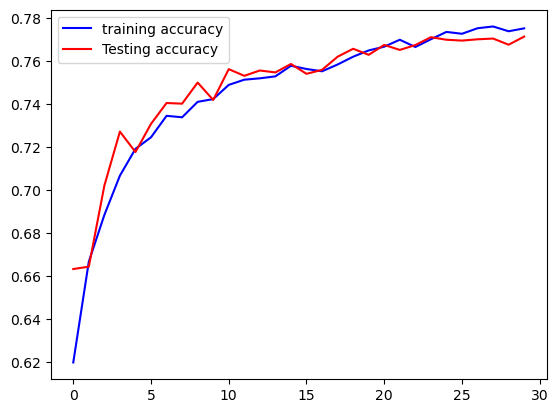

In [22]:
## creating an accuracy graph for training and testing data
plt.plot(history.history['accuracy'],color='blue',label='training accuracy')
plt.plot(history.history['val_accuracy'],color='red',label='Testing accuracy')
plt.legend()
plt.show()

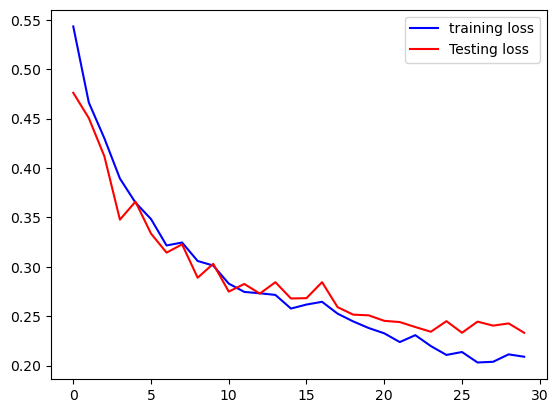

In [23]:
## creating an loss graph for training and testing data
plt.plot(history.history['loss'],color='blue',label='training loss')
plt.plot(history.history['val_loss'],color='red',label='Testing loss')
plt.legend()
plt.show()

<h3 style="color:#F20000;">Visualiser une image aléatoire, son masque originaire et celui prédit</h3>

1/1 [==============================] - 0s 19ms/step


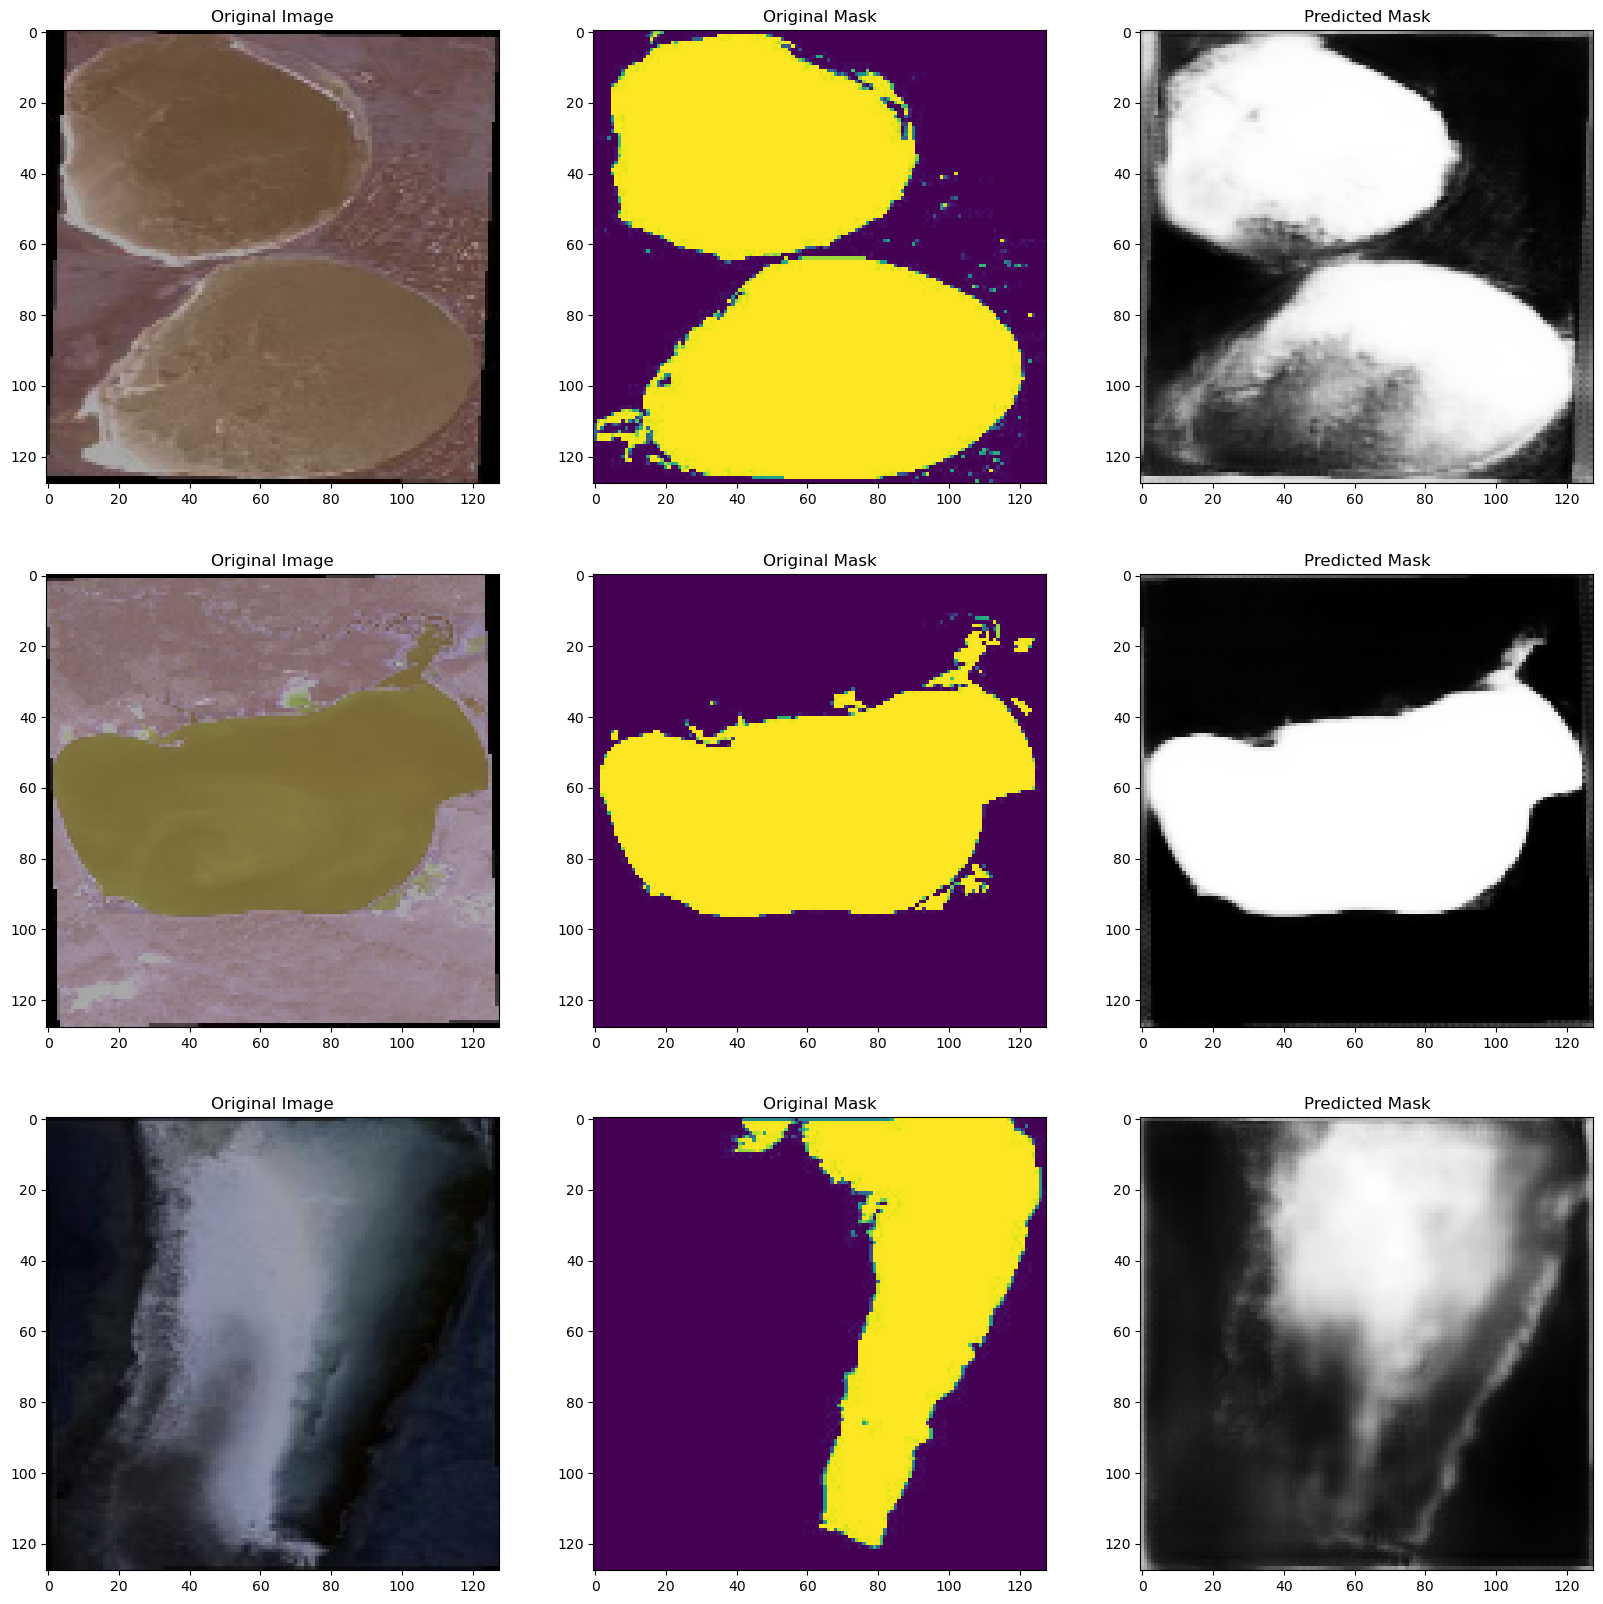

In [24]:
figure, axes = plt.subplots(3,3, figsize=(20,20))

for i in range(0,3):
    rand_num = random.randint(0,50)
    original_img = X_test[rand_num]
    axes[i,0].imshow(original_img)
    axes[i,0].title.set_text('Original Image')
    
    original_mask = y_test[rand_num]
    axes[i,1].imshow(original_mask)
    axes[i,1].title.set_text('Original Mask')
    
    original_img = np.expand_dims(original_img, axis=0) #la dimension du tableau sera incrémenté suivant les lignes (axis=0)
    predicted_mask = model.predict(original_img).reshape(128,128)#prediction du masque de l'image d'entrée
    axes[i,2].imshow(predicted_mask, cmap='gray')
    axes[i,2].title.set_text('Predicted Mask')


In [25]:
TEST_path = "/kaggle/input/rgb-images-test/*.jpg"

In [26]:
TEST_path = sorted(glob.glob(TEST_path), key=lambda x: x.split('.')[0])

In [27]:
img_TEST = []
for image in TEST_path:
# charger les images d'origine sans modifier les couleurs (-1)
    img = cv2.imread(image, -1)
# redimensionner l'image chargée en 128*128 pixels
    img = img_resize(img, 128, 128)
# ajouter l'image à la liste créée
    img_TEST.append(img)

# transformer la liste en un tableau
img_array = np.array(img_TEST)

In [28]:
len(img_array)

11

In [29]:
#Normalize the data

TEST = normalize_array(img_array)

In [30]:
len(TEST)

11

In [31]:
TEST[0].shape


(128, 128, 3)

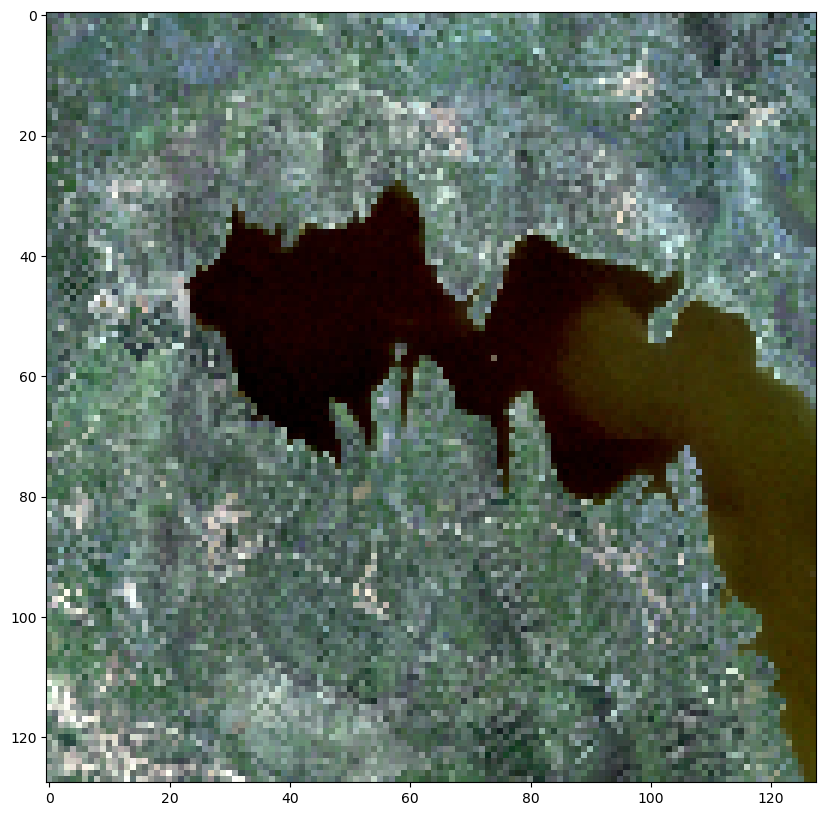

In [37]:

figure, axes = plt.subplots(1,1, figsize=(10,10))

#le premier 'axes' correspond à l'image et le deuxième à son masque
axes.imshow(TEST[4])

In [33]:
prediction = model.predict(TEST)

1/1 [==============================] - 1s 1s/step


1/1 [==============================] - 0s 20ms/step


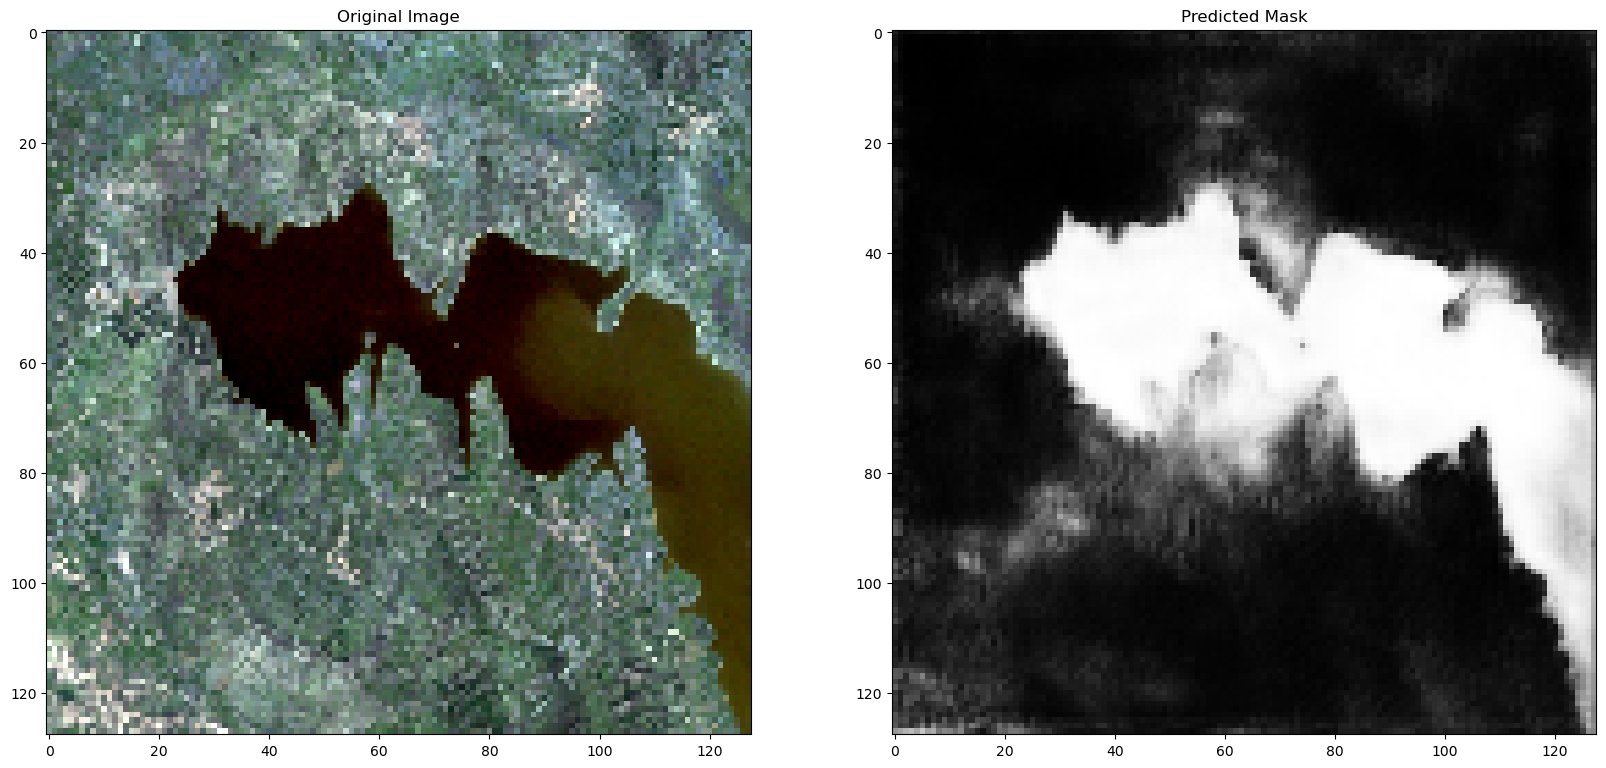

In [38]:
figure, axes = plt.subplots(1,2, figsize=(20,20))
original_img = TEST[4]
original_img = np.expand_dims(original_img, axis=0) #la dimension du tableau sera incrémenté suivant les lignes (axis=0)
predicted_mask = model.predict(original_img).reshape(128,128)#prediction du masque de l'image d'entrée
axes[0].imshow(TEST[4])
axes[0].title.set_text('Original Image')
axes[1].imshow(predicted_mask, cmap='gray')
axes[1].title.set_text('Predicted Mask')

<h3 style="color:#F20000;">Conclusion</h3>

<strong>
   En utilisant le modèle UNet, la précison est de 77%, pourtant au niveau des images Sentinel importées les prédictons fournies ne sont pas satisfaisantes et donc on pense en premier lieu à changer le modèle et utiliser Trans-UNet puis SWIR-UNet et décider le bon choix à établir en terme d'architecture</strong>